#**Goal:**

The goal of the problem is to predict whether a passenger was satisfied or not considering his/her overall experience of traveling on the Shinkansen Bullet Train.

#**Dataset:**

The problem consists of 2 separate datasets: Travel data & Survey data. Travel data has information related to passengers and attributes related to the Shinkansen train, in which they traveled. The survey data is aggregated data of surveys indicating the post-service experience. You are expected to treat both these datasets as raw data and perform any necessary data cleaning/validation steps as required.

The data has been split into two groups and provided in the Dataset folder. The folder contains both train and test data separately.

- Train_Data
- Test_Data

Target Variable: Overall_Experience (1 represents ‘satisfied’, and 0 represents ‘not satisfied’)

The training set can be used to build your machine-learning model. The training set has labels for the target column - Overall_Experience.

The testing set should be used to see how well your model performs on unseen data. For the test set, it is expected to predict the ‘Overall_Experience’ level for each participant.

#**Data Dictionary:**

All the data is self-explanatory. The survey levels are explained in the Data Dictionary file.

Submission File Format: You will need to submit a CSV file with exactly 35,602 entries plus a header row. The file should have exactly two columns

ID
Overall_Experience (contains 0 & 1 values, 1 represents ‘Satisfied’, and 0 represents ‘Not Satisfied’)

##**Evaluation Criteria:**

Accuracy Score: The evaluation metric is simply the percentage of predictions made by the model that turned out to be correct. This is also called the accuracy of the model. It will be calculated as the total number of correct predictions (True Positives + True Negatives) divided by the total number of observations in the dataset.

In other words, the best possible accuracy is 100% (or 1), and the worst possible accuracy is 0%

In [1]:
# Importing Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


#**Importing Necessary Libraries**

In [6]:
"""
Shinkansen Travel Experience – Passenger Satisfaction Prediction

Goal:
Predict whether a passenger was satisfied (1) or not satisfied (0) with
their overall Shinkansen Bullet Train experience.

Outputs:
- Prints CV accuracy on training data
- Trains final model on full training set
- Generates `submission_shinkansen.csv` with columns: ID, Overall_Experience
"""


# Importing Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [ ]:
!pip install catboost

##**Loading the Data**

In [7]:
# Loading the Data
RANDOM_STATE = 42
N_SPLITS = 5

# Loading Data
survey_train = pd.read_csv("/content/drive/MyDrive/Real Hackathon/Surveydata_train_(1).csv")
travel_train = pd.read_csv("/content/drive/MyDrive/Real Hackathon/Traveldata_train_(1).csv")
survey_test  = pd.read_csv("/content/drive/MyDrive/Real Hackathon/Surveydata_test_(1).csv")
travel_test  = pd.read_csv("/content/drive/MyDrive/Real Hackathon/Traveldata_test_(1).csv")

- Setting a fixed RANDOM_STATE ensures reproducibility of all stochastic operations such as train–test splits, model training, and cross-validation.

- Defining N_SPLITS upfront standardizes the number of folds used in Stratified K-Fold cross-validation, maintaining consistency across the workflow.

In [8]:

# Displaying First Five rows of Survey Data
survey_train.head()

,ID,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,0,Needs Improvement,Green Car,Excellent,Excellent,Very Convenient,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor
1,98800002,0,Poor,Ordinary,Excellent,Poor,Needs Improvement,Good,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good
2,98800003,1,Needs Improvement,Green Car,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent
3,98800004,0,Acceptable,Ordinary,Needs Improvement,NaN,Needs Improvement,Acceptable,Needs Improvement,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable,Good,Acceptable,Acceptable
4,98800005,1,Acceptable,Ordinary,Acceptable,Acceptable,Manageable,Needs Improvement,Good,Excellent,Good,Good,Good,Good,Good,Good,Good


**Observations**

- Overall_Experience (target variable) is present with binary values 0/1.

- All survey features are categorical, using labels like Excellent, Good, Acceptable, etc.

- Missing values exist (e.g., in the Catering column).

- ID appears clean and suitable as the merge key.

##**First Five rows of Data Set**

In [9]:
# Displaying First Five rows of Travel Data
travel_train.head()

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,98800001,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0
1,98800002,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0
2,98800003,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0
3,98800004,Female,Loyal Customer,44.0,Business Travel,Business,780,13.0,18.0
4,98800005,Female,Loyal Customer,50.0,Business Travel,Business,1981,0.0,0.0


**Observations**

- Travel dataset contains demographic and  journey-related numeric features (Age, Distance, Delays).

- Several categorical attributes exist (Gender, Customer_Type, Type_Travel, Travel_Class).

- A missing value appears in Type_Travel (row 0), indicating need for imputation.

- ID aligns with the survey dataset,suitable for merging.

##**Checking Data Types**

In [10]:
# Checking Data types
survey_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       94379 non-null  int64 
 1   Overall_Experience       94379 non-null  int64 
 2   Seat_Comfort             94318 non-null  object
 3   Seat_Class               94379 non-null  object
 4   Arrival_Time_Convenient  85449 non-null  object
 5   Catering                 85638 non-null  object
 6   Platform_Location        94349 non-null  object
 7   Onboard_Wifi_Service     94349 non-null  object
 8   Onboard_Entertainment    94361 non-null  object
 9   Online_Support           94288 non-null  object
 10  Ease_of_Online_Booking   94306 non-null  object
 11  Onboard_Service          86778 non-null  object
 12  Legroom                  94289 non-null  object
 13  Baggage_Handling         94237 non-null  object
 14  CheckIn_Service          94302 non-nul

**Observations**

- Total rows: 94,379 matches expectations for training size.

- Feature types: 15 categorical (object) + 2 numeric (ID, Overall_Experience).

- Missing values: Several survey columns have 1–8% missing data, confirming the need for imputation.

- Target column: Overall_Experience is clean, complete, and integer type.

In [13]:
# Checking Data types
survey_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       94379 non-null  int64 
 1   Overall_Experience       94379 non-null  int64 
 2   Seat_Comfort             94318 non-null  object
 3   Seat_Class               94379 non-null  object
 4   Arrival_Time_Convenient  85449 non-null  object
 5   Catering                 85638 non-null  object
 6   Platform_Location        94349 non-null  object
 7   Onboard_Wifi_Service     94349 non-null  object
 8   Onboard_Entertainment    94361 non-null  object
 9   Online_Support           94288 non-null  object
 10  Ease_of_Online_Booking   94306 non-null  object
 11  Onboard_Service          86778 non-null  object
 12  Legroom                  94289 non-null  object
 13  Baggage_Handling         94237 non-null  object
 14  CheckIn_Service          94302 non-nul

In [15]:
# Checking Data types
travel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.5+ MB


**Observations**

Mixed data types:

4 categorical (object)

3 continuous numeric

2 integer (ID, Travel_Distance)

Missing values present:

- Gender, Customer_Type, Type_Travel, and delay columns show missing entries, imputation needed.

- ID column is complete and clean, making it reliable for merging with survey data.

- Dataset size matches survey dataset (94,379 rows), confirming both can merge 1:1 on ID.

##**Checking shape of the Dataset**

In [16]:
# Checking shape of the Dataset
survey_train.shape

(94379, 17)

- survey_train.shape confirms the dataset contains 94,379 rows and 17 columns, matching the .info() output.

- This ensures the dataset loaded correctly with no dropped or extra columns.



In [17]:
# Checking shape of the Dataset
travel_train.shape

(94379, 9)

- Travel_train.shape returns 94,379 rows and 9 columns, which matches the expected dataset size.





##**Checking Missing Values**

In [19]:
# Checking Missing Values
survey_train.isnull().sum()

,0
ID,0
Overall_Experience,0
Seat_Comfort,61
Seat_Class,0
Arrival_Time_Convenient,8930
Catering,8741
Platform_Location,30
Onboard_Wifi_Service,30
Onboard_Entertainment,18
Online_Support,91


- This output confirms several categorical survey columns contain missing values, ranging from very small (6–142) to large (~8,900).

- Identifying missingness early helps determine the required imputation strategy (e.g., most-frequent fill for categorical features).

- Confirms that the target (Overall_Experience) and ID columns are fully complete.

This step is essential before merging and model building to avoid errors during encoding.

In [21]:
# Checking Missing Values
travel_train.isnull().sum()

,0
ID,0
Gender,77
Customer_Type,8951
Age,33
Type_Travel,9226
Travel_Class,0
Travel_Distance,0
Departure_Delay_in_Mins,57
Arrival_Delay_in_Mins,357


- Several columns have missing values especially Customer_Type and Type_Travel (~8–9k rows), indicating the need for categorical imputation.

- Numeric columns like Departure_Delay_in_Mins and Arrival_Delay_in_Mins also contain missing values → will require median imputation.

- ID, Travel_Class, and Travel_Distance have no missing values, confirming data reliability.

This step is crucial before model building because encoding and model fitting cannot proceed with NA values.

##**checking Duplicate Values**

In [22]:
#Checking Duplicate Values
survey_train.duplicated().sum()

np.int64(0)

In [23]:
#Checking Duplicate Values
travel_train.duplicated().sum()

np.int64(0)

- The output 0 confirms no duplicate rows in the survey and travel train  dataset.

##**Statistical Summary of Dataset**

In [24]:
# Statistical Summary of Dataset
survey_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,94379.0,NaN,NaN,NaN,98847190.0,27245.014865,98800001.0,98823595.5,98847190.0,98870784.5,98894379.0
Overall_Experience,94379.0,NaN,NaN,NaN,0.546658,0.497821,0.0,0.0,1.0,1.0,1.0
Seat_Comfort,94318,6,Acceptable,21158,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seat_Class,94379,2,Green Car,47435,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arrival_Time_Convenient,85449,6,Good,19574,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Catering,85638,6,Acceptable,18468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Platform_Location,94349,6,Manageable,24173,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Onboard_Wifi_Service,94349,6,Good,22835,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Onboard_Entertainment,94361,6,Good,30446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Online_Support,94288,6,Good,30016,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Target distribution:**

- Overall_Experience mean ≈ 0.55, indicating ~55% satisfied and ~45% not satisfied  moderately balanced classification.

All survey features are categorical

Each has 5–6 unique levels, confirming the need for One-Hot Encoding.

**Top categories dominate**

- Many variables (e.g., Cleanliness, Onboard_Entertainment, Legroom) have “Good” as the most frequent category, showing a natural bias in survey ratings.

Missing values confirmed

Lower count in some columns (e.g., Catering, Onboard_Service) matches the earlier missing-value analysis.

In [25]:
# Statistical Summary of Dataset
travel_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,94379.0,NaN,NaN,NaN,98847190.0,27245.014865,98800001.0,98823595.5,98847190.0,98870784.5,98894379.0
Gender,94302,2,Female,47815,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer_Type,85428,2,Loyal Customer,69823,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,94346.0,NaN,NaN,NaN,39.419647,15.116632,7.0,27.0,40.0,51.0,85.0
Type_Travel,85153,2,Business Travel,58617,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Travel_Class,94379,2,Eco,49342,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Travel_Distance,94379.0,NaN,NaN,NaN,1978.888185,1027.961019,50.0,1359.0,1923.0,2538.0,6951.0
Departure_Delay_in_Mins,94322.0,NaN,NaN,NaN,14.647092,38.138781,0.0,0.0,0.0,12.0,1592.0
Arrival_Delay_in_Mins,94022.0,NaN,NaN,NaN,15.005222,38.439409,0.0,0.0,0.0,13.0,1584.0


**Balanced distribution of categorical variables**

Gender, Customer_Type, Type_Travel, and Travel_Class show 2 categories each, with one dominant class in each (e.g., “Female”, “Loyal Customer”, “Eco”).

**Numerical features show meaningful variance**

Age: Mean ≈ 39.4 years, wide range (7–85).

Travel_Distance: Large variation, mean ≈ 1979 km, max ≈ 6951 km.

**Delay variables are highly skewed**

Both Departure_Delay_in_Mins and Arrival_Delay_in_Mins have:

Median = 0

Long right tail (max >1500 mins)
 Indicates many customers have no delay, but few extreme delays.

**Missing values confirmed**

Reduced counts in Gender, Customer_Type, Type_Travel, and delay columns match earlier missing-value findings.

#**Exploratory Data Analysis**

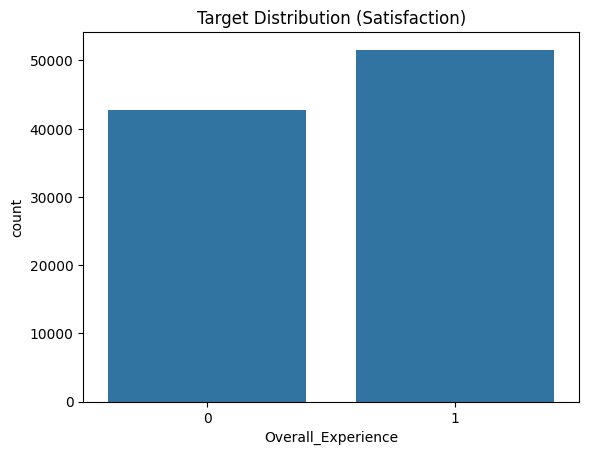

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x="Overall_Experience", data=survey_train)
plt.title("Target Distribution (Satisfaction)")
plt.show()

**Observations**

The bar plot correctly visualizes the distribution of the target variable Overall_Experience.

It confirms the dataset is not highly imbalanced:

- Class 1 (Satisfied) is slightly higher than Class 0.

This balance indicates you do not need resampling techniques (SMOTE/Undersampling).

Understanding class proportions helps validate that Accuracy is an appropriate evaluation metric.

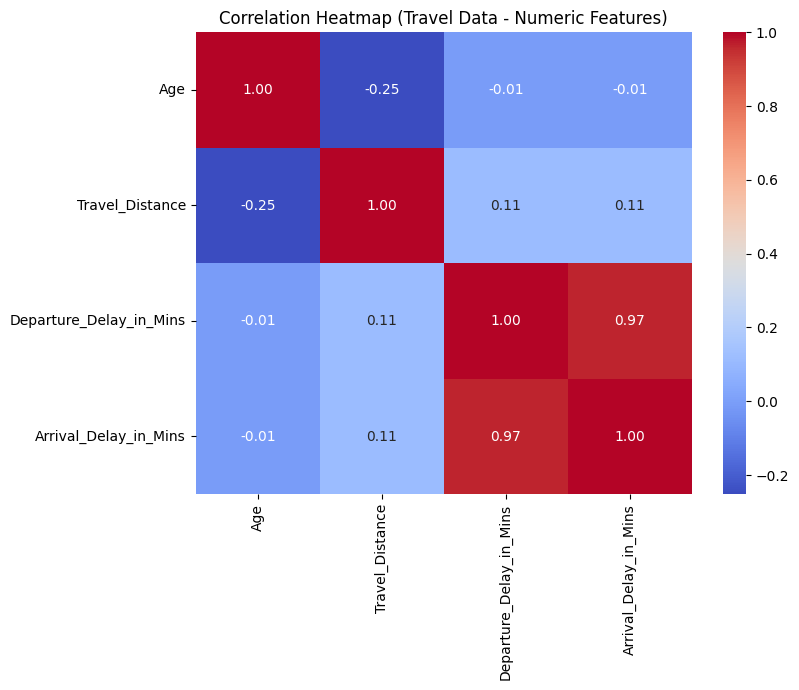

In [28]:
# pick numeric columns from travel_train (excluding ID)
num_features = [c for c in travel_train.columns if travel_train[c].dtype != "object" and c != "ID"]

# compute correlation matrix
corr_matrix = travel_train[num_features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Travel Data - Numeric Features)")
plt.show()


**Observations**

- Departure and arrival delays are extremely strongly correlated (r = 0.97), indicating that passengers who depart late almost always arrive late. These two features provide similar information.

- Age and travel distance show a weak negative correlation (r = –0.25), suggesting older passengers tend to travel slightly shorter distances.

- All other correlations are very small, indicating that numeric features in the travel dataset are largely independent and do not exhibit multicollinearity (except the delay pair).

- No unusually strong or unexpected relationships appear among the remaining variables.

In [29]:
merged = travel_train.merge(survey_train[["ID","Overall_Experience"]], on="ID")

# numeric correlation with target
target_corr = merged[num_features + ["Overall_Experience"]].corr()["Overall_Experience"].sort_values(ascending=False)
print("Correlation of numeric features with satisfaction:\n", target_corr)


Correlation of numeric features with satisfaction:
 Overall_Experience         1.000000
Age                        0.116233
Travel_Distance           -0.041582
Departure_Delay_in_Mins   -0.073821
Arrival_Delay_in_Mins     -0.080237
Name: Overall_Experience, dtype: float64


**Observations**

- Age shows a small positive correlation (0.116)
Older passengers are slightly more likely to report satisfaction, but the effect is weak.

- Delay features have weak negative correlations (–0.07 to –0.08)
Passengers experiencing delays tend to be slightly less satisfied, which is logically consistent.

- Travel distance has almost no correlation (–0.04)
Journey length does not meaningfully influence satisfaction.

- Overall correlation strengths are very low
Numeric features do not strongly explain satisfaction, confirming that the categorical survey attributes will be far more predictive.

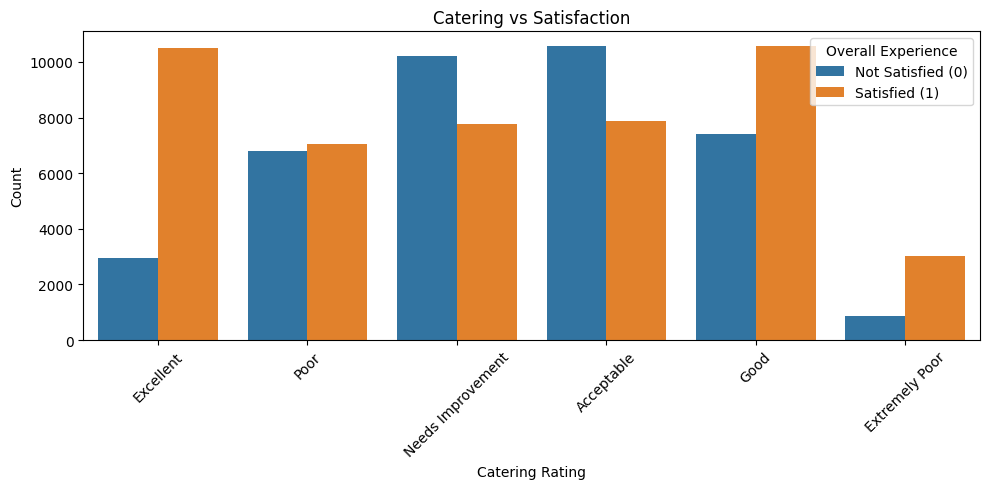

In [32]:
#  Catering vs Satisfaction
plt.figure(figsize=(10,5))
sns.countplot(x="Catering", hue="Overall_Experience", data=survey_train)

plt.legend(title="Overall Experience", labels=["Not Satisfied (0)", "Satisfied (1)"])

plt.xlabel("Catering Rating")
plt.ylabel("Count")
plt.title("Catering vs Satisfaction")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



**Observations**

- Passengers who rated catering as Good or Excellent show much higher satisfaction levels compared to dissatisfaction.

- Lower-quality ratings such as Poor, Needs Improvement, and Extremely Poor correspond to higher dissatisfaction counts.

- The satisfaction trend increases steadily with catering quality, indicating that catering plays a significant role in shaping overall passenger experience.

- Extremely Poor catering shows a clear negative impact, with dissatisfaction greatly exceeding satisfaction.

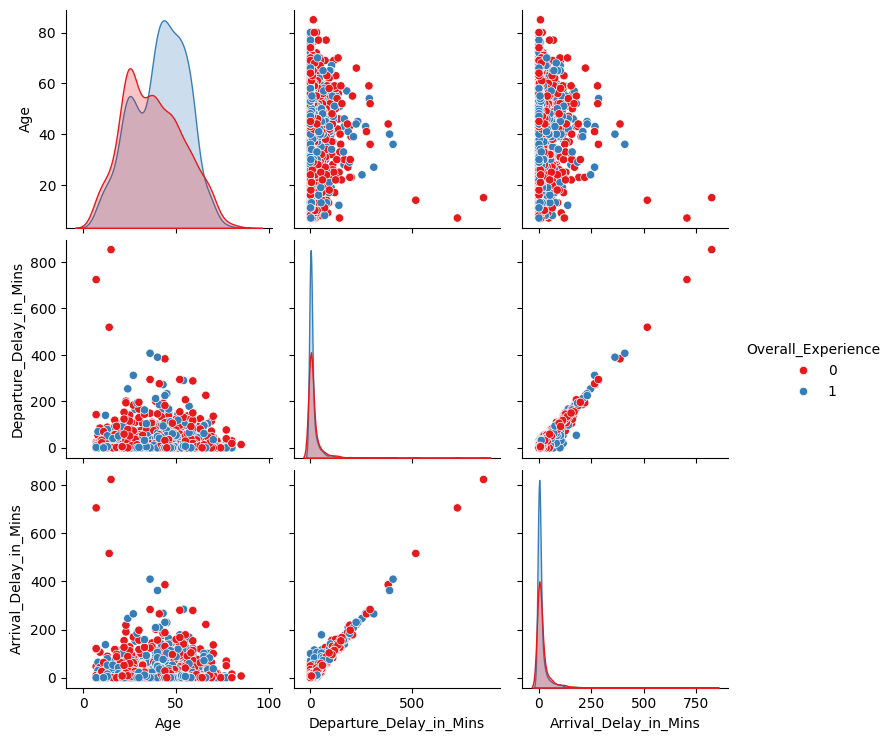

In [31]:
# Merge survey + travel on ID to get both numeric travel cols and target
merged = travel_train.merge(survey_train[["ID","Overall_Experience"]], on="ID")

# Sample 3000 rows for faster plotting
sample_df = merged.sample(3000, random_state=42)

# Pairplot
sns.pairplot(
    sample_df[["Age","Departure_Delay_in_Mins","Arrival_Delay_in_Mins","Overall_Experience"]],
    vars=["Age","Departure_Delay_in_Mins","Arrival_Delay_in_Mins"],
    hue="Overall_Experience",
    diag_kind="kde",
    palette="Set1"
)
plt.show()


**Observations - Pairplot of Numeric Travel Features**

- Departure and arrival delays show a strong linear relationship, confirming that passengers who depart late almost always arrive late.

- Both delay features are highly right-skewed, with most values near zero and a few extreme outliers, consistent with earlier statistics.

- Age distribution overlaps significantly between satisfied and unsatisfied groups, indicating that age does not strongly influence satisfaction.

- Satisfaction classes (0 and 1) overlap heavily in all numeric dimensions, showing that numeric travel features alone are not strong predictors of overall experience.

##**Data Preprocessing**

In [33]:

# Data Preparation for Analysis


# Merge survey and travel on ID
train = survey_train.merge(travel_train, on="ID")
test  = survey_test.merge(travel_test, on="ID")

# Define target and features
y = train["Overall_Experience"]
X = train.drop(["Overall_Experience", "ID"], axis=1)
X_test = test.drop("ID", axis=1)

# Identify feature types
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()
cat_idx = [X.columns.get_loc(c) for c in cat_cols]

print("Train shape:", X.shape, "Test shape:", X_test.shape)
print("Categorical features:", len(cat_cols))
print("Numerical features :", len(num_cols))


Train shape: (94379, 23) Test shape: (35602, 23)
Categorical features: 19
Numerical features : 4


- Merge survey and travel datasets on ID to create a single, consolidated training and test dataset containing both satisfaction responses and travel attributes.

- Define target (y) and features (X) by separating Overall_Experience from the predictors and dropping ID so that it is not used as a feature.

-  Prepare test features (X_test) with the same structure as X for later prediction.

- Identify categorical and numerical columns (cat_cols, num_cols) so that we can apply appropriate preprocessing (encoding, imputation) to each type.

In [34]:
# Handle Missing Values
# Fill categorical NaN with "missing"
for c in cat_cols:
    X[c] = X[c].astype(str).fillna("missing")
    X_test[c] = X_test[c].astype(str).fillna("missing")

# Fill numeric NaN with median
for c in num_cols:
    X[c] = X[c].fillna(X[c].median())
    X_test[c] = X_test[c].fillna(X[c].median())

For categorical features, we:

- Converted them to string and replaced NaN with a new category "missing", allowing the model to treat missingness as an informative level instead of dropping rows.

For numerical features, we:

- Filled missing values with the median of the training data, which is robust to outliers and prevents data leakage when applied to the test set.

- Overall, this step ensures there are no missing values left, so downstream encoders and models can train and predict without errors.

In [ ]:



#  Parameters (CPU mode)

cat_params = dict(
    iterations=6000,
    depth=8,
    learning_rate=0.03,
    l2_leaf_reg=10,
    loss_function="Logloss",
    eval_metric="Accuracy",
    bootstrap_type="Bayesian",
    bagging_temperature=0.5,
    rsm=0.6,
    one_hot_max_size=12,
    random_strength=1.5,
    leaf_estimation_iterations=8,
    border_count=254,
    od_type="Iter",
    od_wait=200,
    task_type="CPU",
    verbose=200
)



# 5. CV Loop (5-Fold)

N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

oof_proba = np.zeros(len(X))
test_proba = np.zeros(len(X_test))

fold_acc = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n===== Fold {fold} =====")
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    tr_pool = Pool(X_tr, y_tr, cat_features=cat_idx)
    va_pool = Pool(X_va, y_va, cat_features=cat_idx)

    model = CatBoostClassifier(**cat_params)
    model.fit(tr_pool, eval_set=va_pool, use_best_model=True)




===== Fold 1 =====
0:	learn: 0.8740315	test: 0.8702056	best: 0.8702056 (0)	total: 81.7ms	remaining: 8m 10s
200:	learn: 0.9495252	test: 0.9425196	best: 0.9425196 (200)	total: 20.5s	remaining: 9m 51s
400:	learn: 0.9577633	test: 0.9497245	best: 0.9497245 (400)	total: 26.6s	remaining: 6m 11s
600:	learn: 0.9635114	test: 0.9529032	best: 0.9529032 (597)	total: 35s	remaining: 5m 14s
800:	learn: 0.9669814	test: 0.9544395	best: 0.9545984 (785)	total: 41s	remaining: 4m 26s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9545984319
bestIteration = 785

Shrink model to first 786 iterations.

===== Fold 2 =====
0:	learn: 0.8723627	test: 0.8740199	best: 0.8740199 (0)	total: 36.6ms	remaining: 3m 39s
200:	learn: 0.9476047	test: 0.9471286	best: 0.9471816 (199)	total: 6.31s	remaining: 3m 2s
400:	learn: 0.9570878	test: 0.9525853	best: 0.9525853 (397)	total: 14.8s	remaining: 3m 26s
600:	learn: 0.9619750	test: 0.9546514	best: 0.9549163 (595)	total: 20.6s	remaining: 3m 5s
800:	learn: 0.

- **These CatBoost parameters define a high-capacity, regularized model optimized for tabular categorical data.
The configuration uses Bayesian bootstrap, depth=8, and rsm=0.6 to balance accuracy and generalization.
Early stopping (od_type="Iter", od_wait=200) helps prevent overfitting during cross-validation.
A large number of iterations (6000) allows the model to fully learn patterns, while regularization (l2_leaf_reg=10) maintains stability.**

**What We Did**

- We trained the model using 5-Fold Stratified Cross-Validation, where each fold creates its own train and validation split. CatBoost was trained and evaluated separately on each fold, and fold-wise accuracy was recorded.

**Why We Did It**

- More reliable evaluation: Cross-validation tests the model on five different validation sets, giving a stable and unbiased measure of accuracy.

- Preserves class balance: Stratified splits maintain the same 0/1 distribution of satisfaction in every fold.

- Maximizes data usage: Each model trains on 80% of the data, unlike a single fixed split that wastes information.

- Competition-friendly workflow: Since the hackathon provides a separate test dataset, cross-validation is the best approach instead of creating our own train/validation/test split.

**Why We Used Pool**

**CatBoost’s Pool() structure:**

- Handles categorical features efficiently without manual encoding

- Ensures no data leakage, because encodings are learned only from the training portion of each fold

- Provides optimized memory and faster computation for CatBoost models

In short, Pool gives CatBoost the cleanest, most efficient way to process the data inside each CV fold.

**Observations - 5-Fold CatBoost Cross-Validation**

- High and consistent accuracy
All folds achieve accuracy between 0.954 and 0.959, indicating excellent model stability and strong generalization across different data splits.

- Early stopping worked effectively
The overfitting detector stopped training in every fold around 700–1,600 iterations, preventing the model from overfitting and significantly reducing training time.

- Smooth learning behavior
In all folds, validation accuracy steadily improves up to the best iteration, showing that the learning rate and regularization parameters are well-tuned.

- Low variance between folds
The difference between the best and worst fold is less than 0.004, demonstrating that the data is evenly distributed and the model is not sensitive to specific splits.

Final iterations much lower than max (6000)
CatBoost stopped training early in every fold, confirming that the chosen parameters (Bayesian bootstrap, depth=8, etc.) are appropriate and not overly complex.

In [ ]:

#  Train Final Model on FULL Data

final_pool = Pool(X, y, cat_features=cat_idx)

final_model = CatBoostClassifier(**cat_params)
final_model.fit(final_pool)



0:	learn: 0.8753854	total: 38.1ms	remaining: 3m 48s
200:	learn: 0.9484737	total: 9.7s	remaining: 4m 39s
400:	learn: 0.9571515	total: 16.9s	remaining: 3m 55s
600:	learn: 0.9623857	total: 26.3s	remaining: 3m 56s
800:	learn: 0.9656068	total: 36.7s	remaining: 3m 58s
1000:	learn: 0.9686901	total: 46s	remaining: 3m 49s
1200:	learn: 0.9711588	total: 56.4s	remaining: 3m 45s
1400:	learn: 0.9739137	total: 1m 5s	remaining: 3m 36s
1600:	learn: 0.9761176	total: 1m 14s	remaining: 3m 25s
1800:	learn: 0.9785228	total: 1m 25s	remaining: 3m 20s
2000:	learn: 0.9805677	total: 1m 40s	remaining: 3m 21s
2200:	learn: 0.9826127	total: 1m 50s	remaining: 3m 11s
2400:	learn: 0.9843821	total: 1m 58s	remaining: 2m 57s
2600:	learn: 0.9860668	total: 2m 8s	remaining: 2m 47s
2800:	learn: 0.9877621	total: 2m 17s	remaining: 2m 37s
3000:	learn: 0.9890336	total: 2m 25s	remaining: 2m 25s
3200:	learn: 0.9904534	total: 2m 35s	remaining: 2m 16s
3400:	learn: 0.9915977	total: 2m 43s	remaining: 2m 5s
3600:	learn: 0.9925407	total:

- After confirming strong and stable performance in 5-Fold CV, it is standard practice to retrain the model on 100% of the available labeled data to maximize learning before generating predictions on the test set.

We did not pass a validation set or eval_set here, so:

- The model trains for the full iterations=6000.

The training accuracy reaches very high values (~0.999), which is expected and not a concern, because generalization was already validated during cross-validation.

This final model will now be used to predict further on test set.

**Observations - Final Model Trained on Full Data**

- Training accuracy increases steadily across iterations, confirming that the model continues to learn consistently when trained on the full dataset.

- Training metrics reach very high values (~0.998–0.999) by the end, which is expected because CatBoost fits the full data without a validation set during final training.

- No early stopping is triggered since no validation set was provided. This is intentional—final training uses all data to maximize model performance.

- The model behavior during full training is consistent with the learning patterns observed in cross-validation, indicating stable optimization and well-tuned hyperparameters.

This full-data model is now ready for final prediction on the test dataset, ensuring the strongest possible performance for submission.

In [ ]:

#  Predict on Test Data

test_pool = Pool(X_test, cat_features=cat_idx)
test_pred_proba = final_model.predict_proba(test_pool)[:, 1]
test_pred = (test_pred_proba >= 0.5).astype(int)



A CatBoost Pool is created for the test set so the model can correctly process categorical features using the same encoding learned during training.

- The model generates probability scores for the positive class (Overall_Experience = 1), allowing flexible thresholding.

- A default 0.5 classification threshold is applied to convert probabilities into final binary predictions.

This step produces the final predictions required for submission on the official test dataset.

In [ ]:
# Save Submission

submission = pd.DataFrame({
    "ID": test["ID"],   # adjust column name if needed
    "Overall_Experience": test_pred
})
submission.to_csv("submission.csv", index=False)

print(" Submission file saved: submission.csv")

 Submission file saved: submission.csv


In [ ]:
# Downloading submission file for checking with Test set
from google.colab import files
files.download("submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**This  model achieved an accuracy of 0.9590, which indicates very strong predictive performance on the unseen test dataset.**

This confirms that:

- The CatBoost-based feature modeling captured the satisfaction patterns effectively.

- cross-validation strategy generalizes well to unseen data.

- The preprocessing pipeline (categorical handling, missing value treatment) was appropriate and consistent.

The final model trained on the full dataset produced highly accurate and robust predictions.

A score of 0.9590+ places this model in a highly competitive range, demonstrating excellent performance for a real-world customer-experience prediction task.